# Language Modeling


Let's try the language modeling task by using chariot and Tensorflow.

* Download the WikiText2 dataset by chazutsu.
* Preprocess WikiText2 by chariot.
* Make model by TensorFlow (use tf.keras).
* Train & evaluate the model.

This tutorial needs following libraries.

* chazutsu
* tensorflow
* matplotlib


## Prepare the packages

In [1]:
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as plt

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
def set_path():
    if "../" not in sys.path:
        sys.path.append("../")
    root_dir = Path.cwd()
    return root_dir

ROOT_DIR = set_path()

## Download the Language Modeling Data

In [4]:
import chazutsu
from chariot.storage import Storage

storage = Storage.setup_data_dir(ROOT_DIR)
r = chazutsu.datasets.WikiText2().download(storage.path("raw"))

Read resource from the existed resource(if you want to retry, set force=True).


In [5]:
r.train_data().head(3)

,sentence
0,= Valkyria Chronicles III =
1,Senjō no Valkyria 3 : <unk> Chronicles ( Japa...
2,"The game began development in 2010 , carrying..."


## Preprocess the review text by chariot.

### Make preprocessor

In [6]:
import chariot.transformer as ct
from chariot.language_model_preprocessor import LanguageModelPreprocessor


dp = LanguageModelPreprocessor()
dp.process("sentence")\
    .by(ct.text.UnicodeNormalizer())\
    .by(ct.text.LowerNormalizer())\
    .by(ct.Tokenizer(lang=None))\
    .by(ct.Vocabulary(min_df=5))\
    .by(ct.generator.ShiftedTarget())\
    .fit(r.valid_data())

In [7]:
print(dp.process("sentence").preprocessor.vocabulary.count)

4321


## Make model by TensorFlow

In [8]:
from tensorflow.python import keras as K


vocab_size = dp.process("sentence").preprocessor.vocabulary.count
embedding_size = 100
hidden_size = 100
batch_size = 20
sequence_length = 35


def make_model(vocab_size, embedding_size, hidden_size, dropout=0.5):
    initializer = K.initializers.RandomUniform(minval=-0.1, maxval=0.1)
    model = K.Sequential()
    model.add(K.layers.Embedding(input_dim=vocab_size, output_dim=embedding_size,
                                 embeddings_initializer=initializer))
    model.add(K.layers.Dropout(dropout))
    model.add(K.layers.LSTM(hidden_size, return_sequences=True))
    model.add(K.layers.Dropout(dropout))
    model.add(K.layers.TimeDistributed(K.layers.Dense(vocab_size, activation="softmax",
                                       kernel_initializer=initializer)))
    return model


def perplexity(y_true, y_pred):
    cross_entropy = K.backend.mean(K.backend.sparse_categorical_crossentropy(y_true, y_pred))
    perplexity = K.backend.exp(cross_entropy)
    return perplexity

In [9]:
model = make_model(vocab_size, embedding_size, hidden_size)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=[perplexity])

## Train the Model

In [10]:
class ReportCallback(K.callbacks.Callback):

    def on_epoch_end(self, epoch, logs={}):
        print("Epoch {}: perplexity={}, loss={}, val_perplexity={}, val_loss={},".format(
                epoch, logs["perplexity"], logs["loss"], logs["val_perplexity"], logs["val_loss"]))

In [11]:
generator_step = {"valid":{}, "test": {}}

for kind in generator_step:
    if kind == "valid":
        data = r.valid_data()
    else:
        data = r.test_data()

    steps_per_epoch, generator = dp(data).preprocess().iterator(
                                    batch_size=batch_size,
                                    sequence_length=sequence_length,
                                    sequencial=False)

    generator_step[kind]["s"] = steps_per_epoch
    generator_step[kind]["g"] = generator()

In [13]:
metrics = model.fit_generator(generator_step["valid"]["g"], generator_step["valid"]["s"],
                              validation_data=generator_step["test"]["g"], validation_steps=generator_step["test"]["s"],
                              epochs=10, verbose=0, callbacks=[ReportCallback()])

Epoch 0: perplexity=130.4355794187452, loss=4.861905640461406, val_perplexity=86.22195108546767, val_loss=4.445986631304719,
Epoch 1: perplexity=126.21022574002626, loss=4.828620915334732, val_perplexity=84.80072591471118, val_loss=4.429564423339311,
Epoch 2: perplexity=122.82440278100185, loss=4.8015392350368815, val_perplexity=83.23768646772518, val_loss=4.410794723865598,
Epoch 3: perplexity=119.45906201972336, loss=4.7742423776720395, val_perplexity=82.21484150997428, val_loss=4.398573969685754,
Epoch 4: perplexity=116.71584885393987, loss=4.750807269674833, val_perplexity=80.9434184695399, val_loss=4.383059159267781,
Epoch 5: perplexity=113.82345621077741, loss=4.725971526786929, val_perplexity=79.71847536397534, val_loss=4.367789893649345,
Epoch 6: perplexity=111.13288078933466, loss=4.70201063625148, val_perplexity=78.79074753162473, val_loss=4.356158931588018,
Epoch 7: perplexity=108.69707026247119, loss=4.6797301214249405, val_perplexity=77.4724880041078, val_loss=4.3392690011

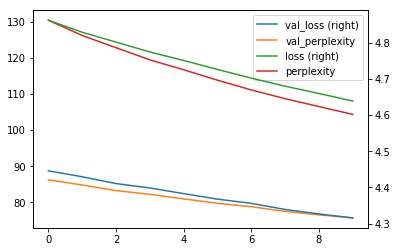

In [14]:
result = pd.DataFrame.from_dict(metrics.history)
result.plot.line(secondary_y=["loss", "val_loss"])

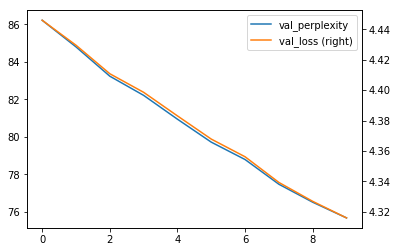

In [15]:
result[["val_perplexity", "val_loss"]].plot.line(secondary_y=["val_loss"])

## Try generating the Text

In [16]:
def generate_text(seed_text, processor, model, sequence_length=10, iteration=20):
    preprocessed = processor.transform([seed_text])[0]

    def pad_sequence(tokens, length):
        if len(tokens) < length:
            pad_size = length - len(tokens)
            return tokens + [processor.vocabulary.pad] * pad_size
        elif len(tokens) > length:
            return tokens[-length:]
        else:
            return tokens

    for _ in range(iteration):
        x = pad_sequence(preprocessed, sequence_length)
        y = model.predict([x])
        index = min(len(preprocessed) - 1, sequence_length - 1)
        target_word_probs = y[index][0]
        w = np.random.choice(np.arange(len(target_word_probs)),
                             1, p=target_word_probs)[0]
        preprocessed.append(w)
    
    decoded = processor.inverse_transform([preprocessed])
    text = " ".join(decoded[0])

    return text

In [18]:
generate_text("when you", dp.process("sentence").preprocessor, model)

'when you african actual printing sound good part @@UNKNOWN@@ @@UNKNOWN@@ @@UNKNOWN@@ city @@UNKNOWN@@ western number @@UNKNOWN@@ six pieces @@UNKNOWN@@ @@UNKNOWN@@ on 18'

In [20]:
generate_text("i wish to", dp.process("sentence").preprocessor, model)

'i wish @@UNKNOWN@@ @@UNKNOWN@@ @@UNKNOWN@@ @@UNKNOWN@@ @@UNKNOWN@@ @@UNKNOWN@@ @@UNKNOWN@@ by @@UNKNOWN@@ @@UNKNOWN@@ @@UNKNOWN@@ @@UNKNOWN@@ mississippi offered @@UNKNOWN@@ elizabeth rookie @@UNKNOWN@@ with @@UNKNOWN@@ @@UNKNOWN@@'

## Stateful Pattern

In [21]:
def make_model_stateful(vocab_size, embedding_size, hidden_size, batch_shape, dropout=0.5):
    initializer = K.initializers.RandomUniform(minval=-0.1, maxval=0.1)
    model = K.Sequential()
    model.add(K.layers.Embedding(input_dim=vocab_size, output_dim=embedding_size,
                                 embeddings_initializer=initializer,
                                 batch_input_shape=batch_shape))
    model.add(K.layers.Dropout(dropout))
    model.add(K.layers.LSTM(hidden_size, stateful=True, return_sequences=True))
    model.add(K.layers.Dropout(dropout))
    model.add(K.layers.TimeDistributed(K.layers.Dense(vocab_size, activation="softmax",
                                       kernel_initializer=initializer)))
    return model

In [22]:
model_s = make_model_stateful(vocab_size, embedding_size, hidden_size, (batch_size, sequence_length))
model_s.compile(loss="sparse_categorical_crossentropy",
                optimizer="adam",
                metrics=[perplexity])

In [23]:
metrics_s = model_s.fit_generator(generator_step["valid"]["g"], generator_step["valid"]["s"],
                                  validation_data=generator_step["test"]["g"], validation_steps=generator_step["test"]["s"],
                                  epochs=10, verbose=0, callbacks=[ReportCallback()])

c:\users\ico\documents\works\chariot\venv\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 0: perplexity=360.8885804723521, loss=5.359977658068548, val_perplexity=93.30824087941369, val_loss=4.5237540671991745,
Epoch 1: perplexity=154.7397674810691, loss=5.031295807635198, val_perplexity=92.06758323935576, val_loss=4.510583569837171,
Epoch 2: perplexity=146.861977348953, loss=4.9795800052705355, val_perplexity=89.66129950589912, val_loss=4.484236864156501,
Epoch 3: perplexity=139.6568931954806, loss=4.929241130391105, val_perplexity=87.45159618244615, val_loss=4.459343951801921,
Epoch 4: perplexity=134.0565957491515, loss=4.888776469621502, val_perplexity=85.24513007319251, val_loss=4.434055060841317,
Epoch 5: perplexity=128.38758432357037, loss=4.845447852963307, val_perplexity=82.69539457143739, val_loss=4.403909667979839,
Epoch 6: perplexity=122.9205834560707, loss=4.802144110007364, val_perplexity=80.24698044532953, val_loss=4.374081534008647,
Epoch 7: perplexity=117.43539986532242, loss=4.756406591759354, val_perplexity=77.71550745187804, val_loss=4.34216463288595

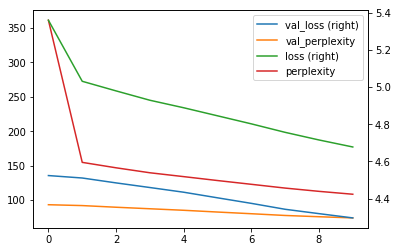

In [24]:
result_s = pd.DataFrame.from_dict(metrics_s.history)
result_s.plot.line(secondary_y=["loss", "val_loss"])

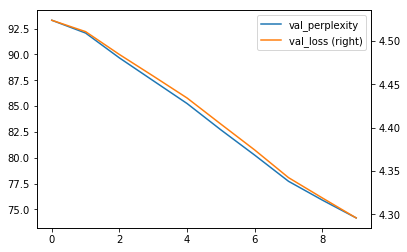

In [25]:
result_s[["val_perplexity", "val_loss"]].plot.line(secondary_y=["val_loss"])

In [27]:
generate_text("champion", dp.process("sentence").preprocessor, model)

"champion karen accounts @@UNKNOWN@@ traffic @@UNKNOWN@@ tropical infantry ) @@UNKNOWN@@ @@UNKNOWN@@ press off @@UNKNOWN@@ @@UNKNOWN@@ men @@UNKNOWN@@ ' @@UNKNOWN@@ city @@UNKNOWN@@"